# Fake Painter

[chainer-goph](https://github.com/mattya/chainer-gogh) に啓発されて作ってみました。

動作環境
- Windows, MacOS, Linux で動作確認済み。いずれも Anaconda
- chainer 2.0
- python3.6 （3.5でもよい）
- opencv 3.2 (3.0でもよい。２でもよいかも） PILだけでも書けると思うが、本人が PIL より慣れてるためちょっとだけ使った。 

chainer-goph との違いは、元の色合いに似せる項を追加していること。
最初原画をかなりぼかした画像と、生成画像をぼかした画像の距離を評価関数にしていたが、そこまでしなくてもいいという結論に達した。
ぼかすのは、この項が聞きすぎるとスタイル感が出ないかと思ったからだが、結局そのあたりは重みを調整すればよさそうである。

In [1]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from PIL import ImageFilter
from io import BytesIO
import urllib.request
import cv2

mean = [103.939, 116.779, 123.68]   # BGR
#  modelVGG = VGG16Layers()

from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# 基本入出力関数

# url を指定して画像を読み込み
def url2img(url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    img =PIL.Image.fromarray(img[:, :, ::-1].copy())
    return img

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(np.clip(blob,0,255)))

# blob データを画像として保存
def save_image(blobimg, it, fn = "frames",mean =mean):
    image = blob2img(blobimg, mean=mean)
    image.save(fn+"/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(ch*size) # 相関行列
    return matrix

In [3]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(400.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
CROPSIZE = (3,224,224)
iter = 5000  # 繰り返し回数

class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(MyVGG,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # ファイルから画像を生成
    def setImage(self,filename, withsmooth=False, crop=-1):
        if filename[:4] == "http":
            img = url2img(filename)
        else:
            img = PIL.Image.open(filename)
        if crop > 0 :
            x1 = int(img.width-224*crop)/2
            y1 = int(img.height-224*crop)/2
            if x1 > 0 and y1 >0 :
                cbox = (x1,y1,x1+224*crop,y1+224*crop)
                img = img.crop(cbox)            
        nimg = VGGprepare(img)
        if withsmooth:
            self.smimg = img.filter(ImageFilter.GaussianBlur(7))# ぼかしたイメージ 
            nsmimg = VGGprepare(self.smimg)
            return nimg, nsmimg
        else:
            return nimg
        
    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,fname, layers=['vpool4']):
        print('Original image set',fname)
        self.opic, smpic =  self.setImage(fname, withsmooth=True)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)  # 対象画像の特徴情報
        self.Ofeatures = h
        self.vsmimg = smpic
        
    # スタイル画像をセット
    def setSimage(self,fname, layers=['conv4_1'],crop=False):
        print('Style image set',fname)
        self.spic =  self.setImage(fname,crop=crop)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        cor = {}
        for l in h.keys():
            cor.update({l:ch_corr_matrix(h[l])})
        self.Sfeatures = h
        self.Scorr = cor

In [ ]:
nn=MyVGG()

Now loading caffemodel (usually it may take few minutes)


In [19]:
def Myforward(model, x, layers=['conv4_1','conv4_2','conv4_3','pool4']):
    return model(x,layers=layers)
    
def generate(nn,oimg,style,crop = False, cont = False, itr=100,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3','pool4'],fn="frames", interval = 20, start = 0):
        # nn: ネットワーク、oimg：対象画像名, style：スタイル画像, cont: 前回の続き、itr:繰り返し回数, l1: oimgから取り出す階層、l2:style から取り出す階層, 
        # fn: 出力フォルダ名, interval: 出力間隔, start: continue の場合の表示上のカウント数の開始番号
        nn.setOimage(oimg,l1)
        nn.setSimage(style,l2, crop)
        if  cont == False:
            nn.setpic(nn.genpic())

        # train mode
        chainer.config.train=False
        chainer.config.enable_backprop=True

        optimizer = optimizers.Adam(alpha=2e+1, beta1=0.5)
        optimizer.setup(nn.autopic)

        oldx = nn.autopic.W  # 　前回の　x の値の初期値
        oldx.grad = np.zeros_like(oldx.data)  # grad はゼロにセット
        
        for times  in range (start,start+itr):
            nn.cleargrads()  # 微係数データを初期化

            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのチャネル相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W
            efs = Myforward(nn,x,layers=list(set(l1+l2)))  # 前向き伝搬して指定した層のデータを取得
            for key in l1:
                ef = efs[key]
                of = nn.Ofeatures[key].data  # 先に保存してある対象画像の指定層データ
                loss1 += F.mean_squared_error(ef,of)   # 距離を誤差とする
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data) # 先に保存してあるスタイル画像の指定データ
                ecm = ch_corr_matrix(ef)   # チャネル相関マトリクス
                ocm = nn.Scorr[key].data  # 先に保存してあるスタイル画像のチャネル相関マトリクス
                loss2 += F.mean_squared_error(ecm, ocm)  # マトリクス間の自乗誤差

            loss3 = F.mean_squared_error(x, Variable(nn.vsmimg))    # 元の画像におおまかに近づけるための項
            
            loss = rr1*loss1+rr2*loss2+(1-rr1-rr2)*loss3
            loss.backward()

            xgrad = x.grad   #　 loss に対する入力の寄与を保存
            nn.cleargrads()  # nn 全体の微分データをクリア
            x.grad = xgrad
            # nn.autopic.W.grad = xgrad
            x = myoptimize(oldx, x, alpha = lr, beta = 0.5)
            # optimizer.update()
           
            nn.autopic.W = x   # 自動生成画像を更新データで上書き
            if times % interval == 0:
                print("\n{}  {:10.5f}  = {:10.10f} +{:10.10f}+ {:10.10f}".format(times, 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data)    )    
                showarray(blob2img(x.data,mean=mean))
                save_image(x.data, times,fn=fn)                        
            print(times%10, end="")
            
            oldx = x    #  data が　　autoc.W と狂ってくるが grad しかつかわないのでかまわない

        print("\n{}  {:10.5e}  = {:10.5e} +{:10.5e}+ {:10.5e}".format(times, 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data)    )    
        showarray(blob2img(nn.autopic.W.data,mean=mean))
        save_image(x.data, times,fn=fn)                        
            
def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
    return vimg

# 実験用画像

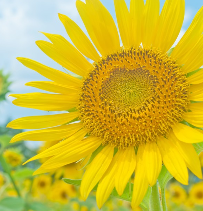

In [6]:
img = PIL.Image.open("himawari.png")
img.resize(np.array(img.size)//4)

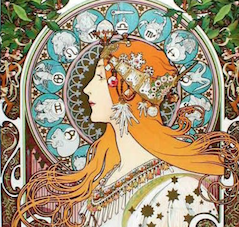

In [7]:
img = PIL.Image.open("Mucha.png")
img.resize(np.array(img.size)//1)

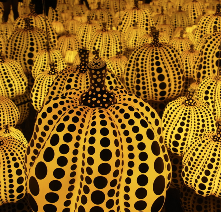

In [8]:
img = PIL.Image.open("kusama.png")
img.resize(np.array(img.size)//2)

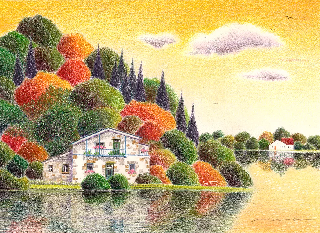

In [73]:
msurl =  'https://goo.gl/ZCnjHJ'
img = url2img(msurl)
img.resize(np.array(img.size)//3)

257.0 126.0 (962, 700)


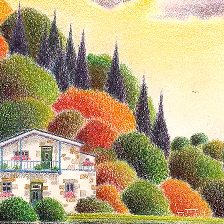

In [70]:
#　crop の場合
crop = 2
x1 = int(img.width-224*crop)/2
y1 = int(img.height-224*crop)/2
print(x1,y1,img.size)
if x1 > 0 and y1 >0 :
    cbox = (x1,y1,x1+224*crop,y1+224*crop)
    img2 = img.crop(cbox)            
img2.resize(np.array(img2.size)//crop)

# まず基本
参照原画に似せる項のみ。当然ながらただちに原画そのものになる。ボケてるのは、ぼかして使っているから。

mkdir: ex0: File exists
Original image set himawari.png
Style image set Mucha.png

0  7451.57324  = 0.0000000000 +0.0000000000+ 7451.5732421875


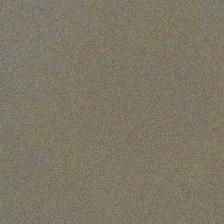

01234567890123456789
20  1464.31995  = 0.0000000000 +0.0000000000+ 1464.3199462891


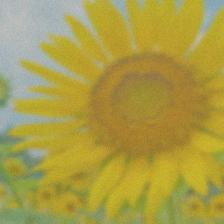

0123456789
29  7.04143e+02  = 0.00000e+00 +0.00000e+00+ 7.04143e+02


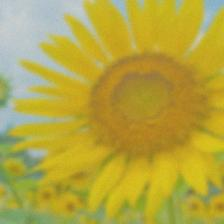

In [11]:
!mkdir ex0
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(0.00)
generate(nn,"himawari.png","Mucha.png",itr=30, fn="ex0")

# 原画の３，４層特徴のみ

mkdir: ex1: File exists
Original image set himawari.png
Style image set Mucha.png

0  34062.04688  = 34062.0468750000 +0.0000000000+ 0.0000000000


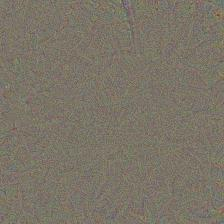

01234567890123456789
20  9296.19922  = 9296.1992187500 +0.0000000000+ 0.0000000000


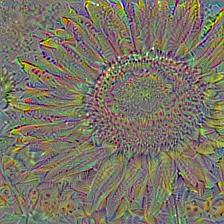

01234567890123456789
40  6471.93164  = 6471.9316406250 +0.0000000000+ 0.0000000000


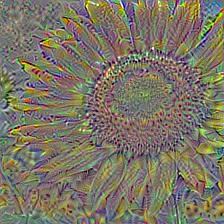

0123456789
49  5.56289e+03  = 5.56289e+03 +0.00000e+00+ 0.00000e+00


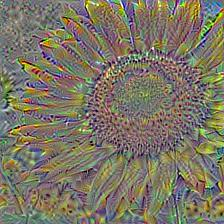

In [12]:
!mkdir ex1
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(1.)
rr2 = np.float32(0.)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex1")

# スタイル画像特徴のみ

## Musha

mkdir: ex2: File exists
Original image set himawari.png
Style image set Mucha.png

0  43934.75000  = 0.0000000000 +43934.7500000000+ 0.0000000000


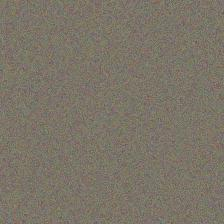

01234567890123456789
20  5685.55908  = 0.0000000000 +5685.5590820312+ 0.0000000000


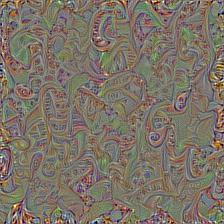

0123456789
29  3.75412e+03  = 0.00000e+00 +3.75412e+03+ 0.00000e+00


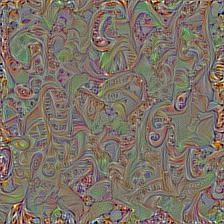

In [15]:
!mkdir ex2
lr = np.float32(100.0) # 学習係数    200 だと発散した
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"himawari.png","Mucha.png",itr=30, fn="ex2")

#  草間彌生 

Original image set himawari.png
Style image set kusama.png

0  260567.51562  = 0.0000000000 +260567.5156250000+ 0.0000000000


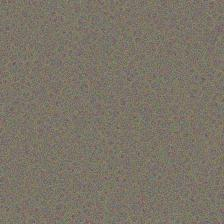

01234567890123456789
20  52917.58203  = 0.0000000000 +52917.5820312500+ 0.0000000000


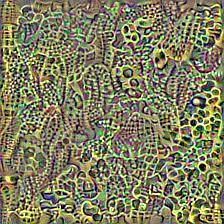

0123456789
29  3.25895e+04  = 0.00000e+00 +3.25895e+04+ 0.00000e+00


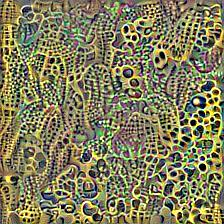

In [16]:
!mkdir ex３
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"himawari.png","kusama.png",itr=30, fn="ex3")

mkdir: ex4: File exists
Original image set himawari.png
Style image set https://goo.gl/ZCnjHJ

0  30823.43555  = 0.0000000000 +30823.4355468750+ 0.0000000000


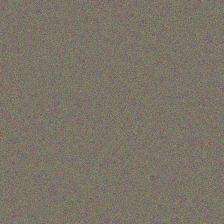

01234567890123456789
20  3655.15381  = 0.0000000000 +3655.1538085938+ 0.0000000000


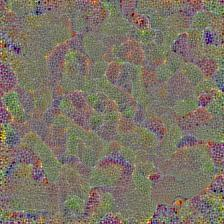

0123456789
29  2.73598e+03  = 0.00000e+00 +2.73598e+03+ 0.00000e+00


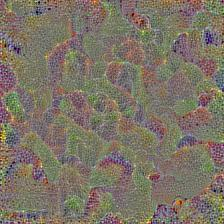

In [17]:
!mkdir ex4
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"himawari.png",msurl,itr=30, fn="ex4")

mkdir: ex5: File exists
Original image set himawari.png
Style image set https://goo.gl/ZCnjHJ

0  16691.39062  = 0.0000000000 +16691.3906250000+ 0.0000000000


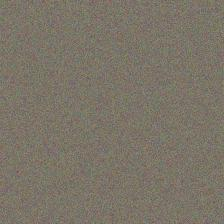

01234567890123456789
20  3427.75708  = 0.0000000000 +3427.7570800781+ 0.0000000000


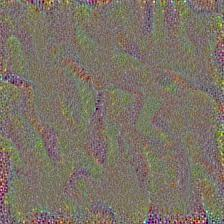

0123456789
29  2.56309e+03  = 0.00000e+00 +2.56309e+03+ 0.00000e+00


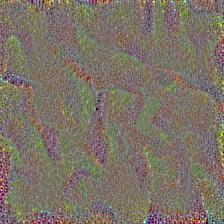

In [23]:
!mkdir ex5
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"himawari.png",msurl,crop=True,itr=30, fn="ex5")

mkdir: ex6: File exists
Original image set himawari.png
Style image set Mucha.png

0  39871.85547  = 4695.5385742188 +35176.3164062500+ -0.0001111907


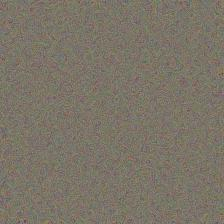

01234567890123456789
20  9417.97168  = 4760.1000976562 +4657.8715820312+ -0.0001187806


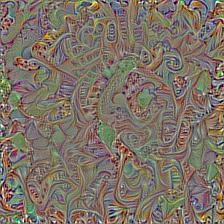

01234567890123456789
40  7301.06104  = 3981.8034667969 +3319.2575683594+ -0.0001207274


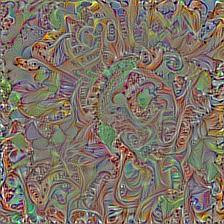

01234567890123456789
60  5816.14453  = 3640.4895019531 +2175.6550292969+ -0.0001224711


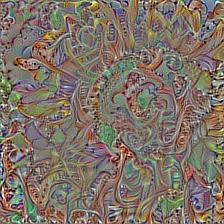

01234567890123456789
80  5387.82080  = 3397.1887207031 +1990.6320800781+ -0.0001233234


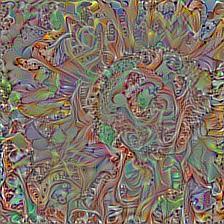

01234567890123456789
100  5011.56055  = 3169.7915039062 +1841.7691650391+ -0.0001241883


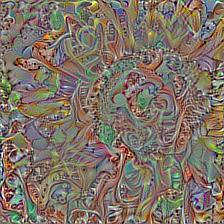

01234567890123456789
120  4763.11035  = 3008.5498046875 +1754.5605468750+ -0.0001249008


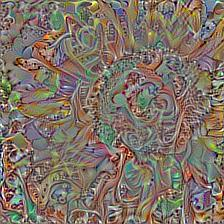

01234567890123456789
140  4670.27100  = 2938.6940917969 +1731.5767822266+ -0.0001253903


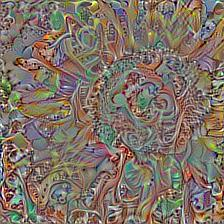

01234567890123456789
160  4509.89160  = 2764.3032226562 +1745.5881347656+ -0.0001259901


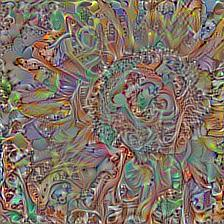

01234567890123456789
180  4357.10938  = 2767.4985351562 +1589.6109619141+ -0.0001264450


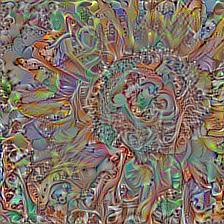

01234567890123456789
200  4240.77246  = 2613.6428222656 +1627.1295166016+ -0.0001269162


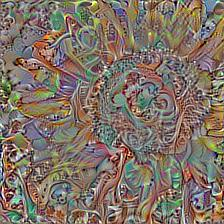

01234567890123456789
220  4125.97754  = 2618.2915039062 +1507.6861572266+ -0.0001272756


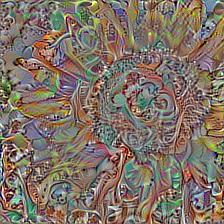

01234567890123456789
240  4020.53345  = 2508.7475585938 +1511.7862548828+ -0.0001276962


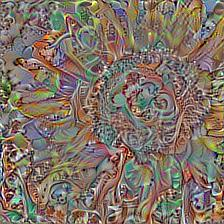

01234567890123456789
260  3941.56421  = 2516.0317382812 +1425.5328369141+ -0.0001280072


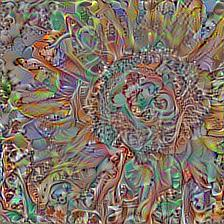

01234567890123456789
280  3915.46802  = 2412.4733886719 +1502.9948730469+ -0.0001283203


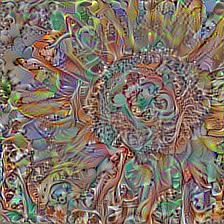

01234567890123456789
300  3836.71948  = 2440.4936523438 +1396.2261962891+ -0.0001286108


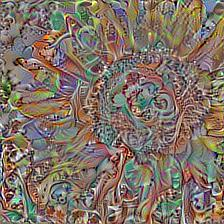

01234567890123456789
320  3804.82544  = 2337.8664550781 +1466.9592285156+ -0.0001288920


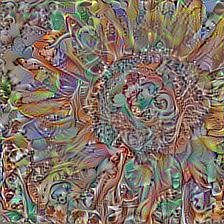

01234567890123456789
340  3732.56958  = 2372.5261230469 +1360.0435791016+ -0.0001291662


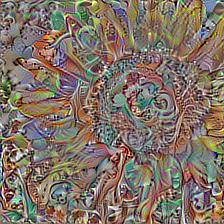

01234567890123456789
360  3718.12720  = 2274.9240722656 +1443.2034912109+ -0.0001293992


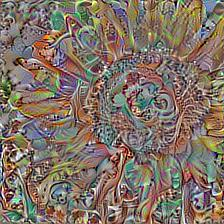

01234567890123456789
380  3619.33569  = 2300.4724121094 +1318.8636474609+ -0.0001296814


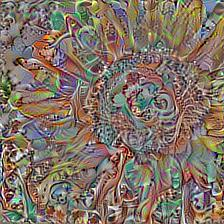

01234567890123456789
400  3583.40649  = 2245.0893554688 +1338.3175048828+ -0.0001299087


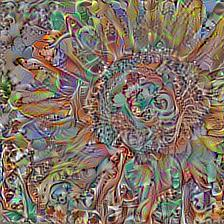

01234567890123456789
420  3547.36401  = 2232.0944824219 +1315.2698974609+ -0.0001301193


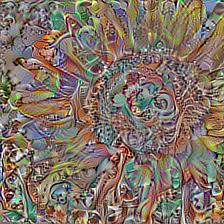

01234567890123456789
440  3507.63013  = 2219.4902343750 +1288.1402587891+ -0.0001303310


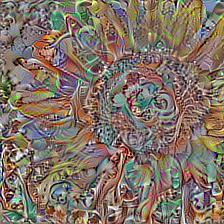

01234567890123456789
460  3508.51904  = 2173.4426269531 +1335.0766601562+ -0.0001304847


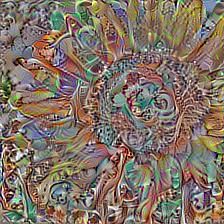

01234567890123456789
480  3463.72754  = 2192.6582031250 +1271.0695800781+ -0.0001306803


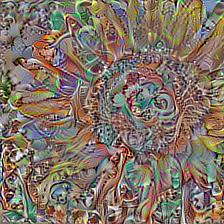

01234567890123456789
499  3.48811e+03  = 2.25317e+03 +1.23494e+03+ -1.31046e-04


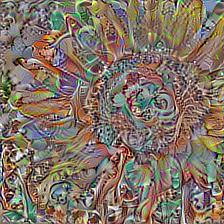

In [27]:
#  loss3 を０   ->  chainer-goph と同じ　　　ただし重みパラメータは適当
!mkdir ex6
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(0.2)
rr2 = np.float32(0.8)
generate(nn,"himawari.png","Mucha.png",l1=['pool4'],itr=500, fn="ex6")

mkdir: ex7: File exists
Original image set himawari.png
Style image set Mucha.png

0  36327.89062  = 13622.3798828125 +21960.1972656250+ 745.3106489354


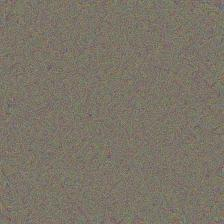

01234567890123456789
20  12262.90625  = 7730.0932617188 +3755.6904296875+ 777.1234888361


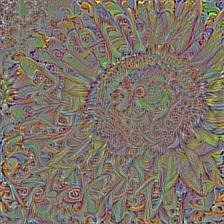

01234567890123456789
40  9829.57324  = 5814.5512695312 +3235.7534179688+ 779.2685570676


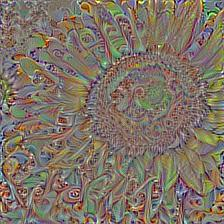

0123456789
49  9.00393e+03  = 5.78073e+03 +2.44218e+03+ 7.81020e+02


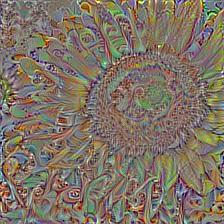

In [29]:
!mkdir ex7
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(0.4)
rr2 = np.float32(0.5)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex7")

mkdir: ex8: File exists
Original image set himawari.png
Style image set Mucha.png

0  23732.71094  = 6817.3945312500 +13181.5791015625+ 3733.7389023978


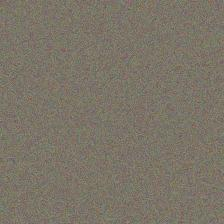

01234567890123456789
20  11202.94922  = 4344.1113281250 +3276.0300292969+ 3582.8072662709


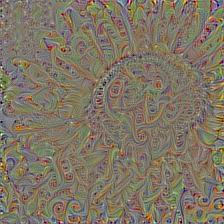

01234567890123456789
40  9090.87305  = 3557.2702636719 +2151.3830566406+ 3382.2201140457


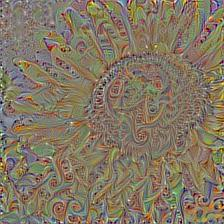

0123456789
49  8.55138e+03  = 3.39701e+03 +1.86205e+03+ 3.29231e+03


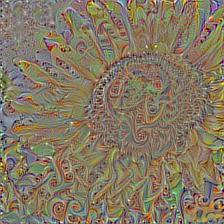

In [30]:
!mkdir ex8
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(0.2)
rr2 = np.float32(0.3)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex8")

mkdir: ex9: File exists
Original image set himawari.png
Style image set Mucha.png

0  9086.68848  = 681.5706787109 +1318.4616699219+ 7086.6558188837


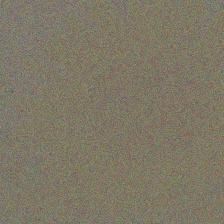

01234567890123456789
20  2236.20703  = 263.7161560059 +377.3624877930+ 1595.1283954312


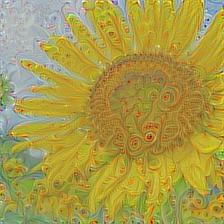

01234567890123456789
40  1009.11230  = 218.6293334961 +316.7031250000+ 473.7798848957


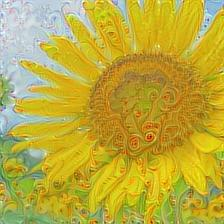

0123456789
49  8.28885e+02  = 2.26988e+02 +2.75693e+02+ 3.26204e+02


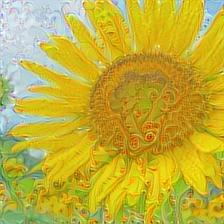

In [31]:
!mkdir ex9
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex9")

mkdir: ex10: File exists
Original image set himawari.png
Style image set kusama.png

0  15592.08789  = 681.6477050781 +7817.6176757812+ 7092.8229331487


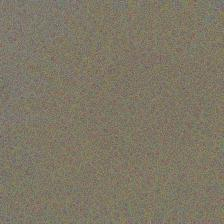

01234567890123456789
20  4311.24316  = 660.6385498047 +1441.6057128906+ 2208.9990992784


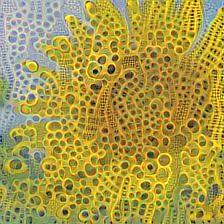

01234567890123456789
40  3206.62549  = 595.0585937500 +1492.9288330078+ 1118.6381055640


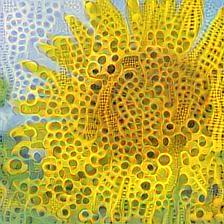

0123456789
49  2.70666e+03  = 6.95331e+02 +8.24141e+02+ 1.18719e+03


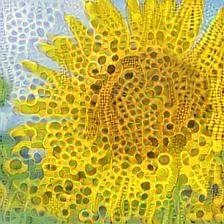

In [32]:
!mkdir ex10
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","kusama.png",itr=50, fn="ex10")

Original image set himawari.png
Style image set https://goo.gl/ZCnjHJ

0  8695.21191  = 681.5059204102 +924.4873657227+ 7089.2182212304


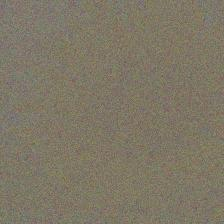

01234567890123456789
20  1998.91504  = 246.6628875732 +189.0586700439+ 1563.1934588702


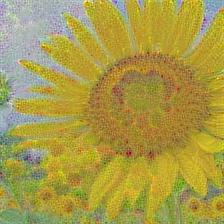

01234567890123456789
40   812.66229  = 200.2683868408 +177.6236877441+ 434.7702199329


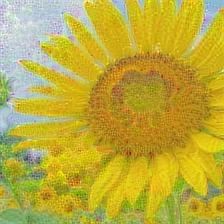

0123456789
49  6.52434e+02  = 1.81238e+02 +1.89664e+02+ 2.81532e+02


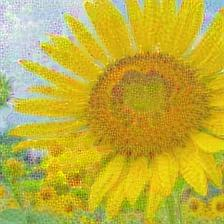

In [33]:
!mkdir ex11
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png",msurl,itr=50, fn="ex11")

Original image set himawari.png
Style image set https://goo.gl/ZCnjHJ

0  8268.40723  = 681.1967163086 +500.6834106445+ 7086.5273276726


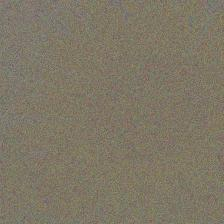

01234567890123456789
20  1866.13818  = 164.7516632080 +183.1571044922+ 1518.2294207314


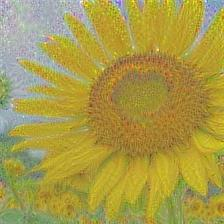

01234567890123456789
40   693.73035  = 128.4583129883 +179.5500488281+ 385.7219761618


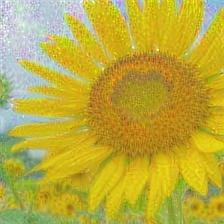

0123456789
49  5.52172e+02  = 1.45604e+02 +1.69936e+02+ 2.36632e+02


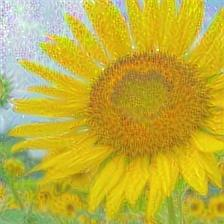

In [34]:
!mkdir ex12
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png",msurl,crop=True,itr=50, fn="ex12")

mkdir: tes: File exists
Original image set Mucha.png
Style image set mstyle.png

0  18186.22852  = 10923.3896484375 +6394.4194335938+ 868.4200001205


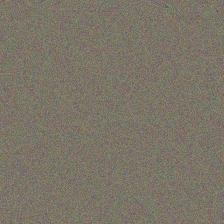

01234567890123456789012345678901234567890123456789
50  5256.88965  = 2846.2402343750 +1544.1519775391+ 866.4973439135


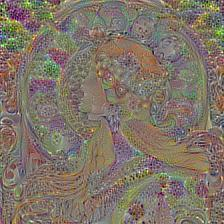

01234567890123456789012345678901234567890123456789
100  4458.62012  = 2359.0322265625 +1308.8192138672+ 790.7686834968


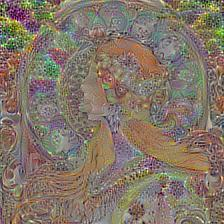

01234567890123456789012345678901234567890123456789
150  4118.21191  = 2168.0075683594 +1229.6379394531+ 720.5665854566


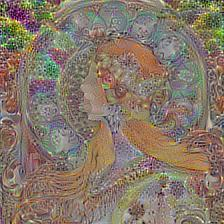

01234567890123456789012345678901234567890123456789
200  3897.28101  = 2013.4836425781 +1224.5590820312+ 659.2382665149


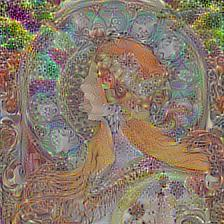

01234567890123456789012345678901234567890123456789
250  3756.31445  = 1969.5736083984 +1180.0799560547+ 606.6609239401


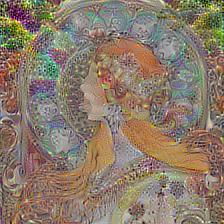

01234567890123456789012345678901234567890123456789
300  3630.40112  = 1888.5535888672 +1179.7893066406+ 562.0583858745


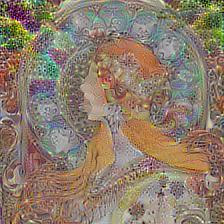

01234567890123456789012345678901234567890123456789
350  3543.58911  = 1884.0363769531 +1135.4361572266+ 524.1164921913


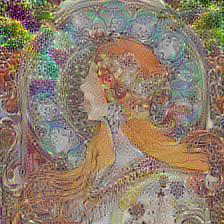

01234567890123456789012345678901234567890123456789
400  3478.57397  = 1867.7449951172 +1118.8709716797+ 491.9580456445


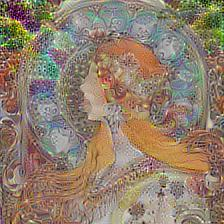

01234567890123456789012345678901234567890123456789
450  3412.79248  = 1823.0208740234 +1125.4799804688+ 464.2916400129


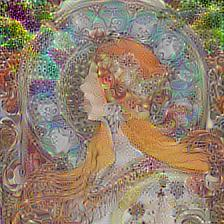

012345678901234567890123456789012345678901234

In [ ]:
!mkdir tes
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(0.2)
rr2 = np.float32(0.4)
generate(nn,"Mucha.png","mstyle.png",itr=500, interval=50,fn="tes")

Original image set Mucha.png
Style image set https://goo.gl/ZCnjHJ

0  4613.48828  = 1639.9208984375 +1001.5944213867+ 1971.9728925429


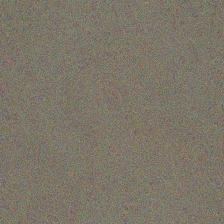

01234567890123456789
20  1460.88477  = 487.7045288086 +330.6277465820+ 642.5524788374


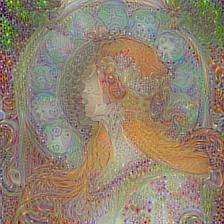

01234567890123456789
40  1086.58948  = 500.7569274902 +258.2539672852+ 327.5785892862


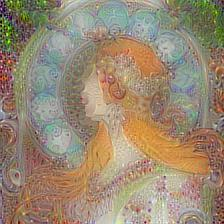

01234567890123456789
60   933.07776  = 370.5333251953 +295.3438720703+ 267.2005279344


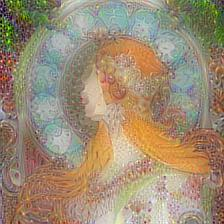

01234567890123456789
80   895.96826  = 395.7262878418 +255.5717163086+ 244.6702797767


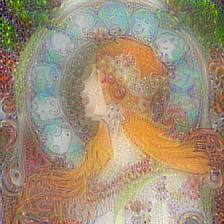

01234567890123456789
99  8.78341e+02  = 3.42414e+02 +2.91415e+02+ 2.44513e+02


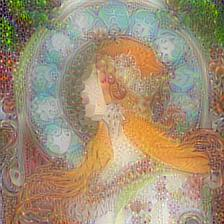

In [41]:
!mkdir tes2
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.03)
rr2 = np.float32(0.06)
generate(nn,"Mucha.png",msurl,crop=True,itr=100, fn="tes2")